In [43]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.inspection import permutation_importance
import optuna

In [3]:
sisu.shape

(5709, 20)

In [4]:
sisu.iloc[:,0:10].head()

,SG_IES,DS_CATEGORIA_ADM,SG_UF_CAMPUS,DS_REGIAO_CAMPUS,NO_MUNICIPIO_CAMPUS,NO_CURSO,DS_GRAU,DS_TURNO,QT_VAGAS_CONCORRENCIA,QT_INSCRICAO
0,UFPE,Pública Federal,PE,Nordeste,Caruaru,QUÍMICA,Licenciatura,Noturno,40,28.0
1,UFPE,Pública Federal,PE,Nordeste,Caruaru,MEDICINA,Bacharelado,Integral,40,221.0
2,UFPE,Pública Federal,PE,Nordeste,Caruaru,PEDAGOGIA,Licenciatura,Noturno,40,150.0
3,UFPE,Pública Federal,PE,Nordeste,Caruaru,COMUNICAÇÃO SOCIAL,Bacharelado,Integral,20,37.0
4,UFPE,Pública Federal,PE,Nordeste,Caruaru,ENGENHARIA DE PRODUÇÃO,Bacharelado,Integral,40,21.0


In [5]:
sisu.iloc[:,10:20].head()

,CI,IGC,POP,HIERARQUIA_URBANA,COD_HIERARQUIA_URBANA,GRUPO_HIERARQUIA_URBANA,IA,IA_Q5,NU_NOTACORTE,curso_smoothed
0,5,4,1488920.0,Metrópole - Integrante de Arranjo Populacional,1C - Integrante de Arranjo Populacional,1,3.002146e+06,2294139.05,625.85,604.450564
1,5,4,1488920.0,Metrópole - Integrante de Arranjo Populacional,1C - Integrante de Arranjo Populacional,1,3.002146e+06,2294139.05,854.48,747.350892
2,5,4,1488920.0,Metrópole - Integrante de Arranjo Populacional,1C - Integrante de Arranjo Populacional,1,3.002146e+06,2294139.05,652.25,606.180478
3,5,4,1488920.0,Metrópole - Integrante de Arranjo Populacional,1C - Integrante de Arranjo Populacional,1,3.002146e+06,2294139.05,715.56,645.970918
4,5,4,1488920.0,Metrópole - Integrante de Arranjo Populacional,1C - Integrante de Arranjo Populacional,1,3.002146e+06,2294139.05,671.32,657.030919


In [2]:
sisu = pd.read_csv('sisu_trabalhado2.csv')

In [6]:
sisu.columns

Index(['SG_IES', 'DS_CATEGORIA_ADM', 'SG_UF_CAMPUS', 'DS_REGIAO_CAMPUS',
       'NO_MUNICIPIO_CAMPUS', 'NO_CURSO', 'DS_GRAU', 'DS_TURNO',
       'QT_VAGAS_CONCORRENCIA', 'QT_INSCRICAO', 'CI', 'IGC', 'POP',
       'HIERARQUIA_URBANA', 'COD_HIERARQUIA_URBANA', 'GRUPO_HIERARQUIA_URBANA',
       'IA', 'IA_Q5', 'NU_NOTACORTE', 'curso_smoothed'],
      dtype='object')

In [7]:
df = sisu[["DS_CATEGORIA_ADM","DS_REGIAO_CAMPUS","DS_GRAU","DS_TURNO","QT_VAGAS_CONCORRENCIA",
     "QT_INSCRICAO","POP","GRUPO_HIERARQUIA_URBANA","IA_Q5","CI","IGC","curso_smoothed","NU_NOTACORTE"]].copy()

# Tratando atributos para modelo

In [12]:
df.CI = df.CI.apply(lambda x: str(x))
df.IGC = df.IGC.apply(lambda x: str(x))

In [8]:
df.DS_CATEGORIA_ADM.value_counts()

Pública Federal      4468
Pública Estadual     1240
Pública Municipal       1
Name: DS_CATEGORIA_ADM, dtype: int64

In [9]:
df.DS_CATEGORIA_ADM = df.DS_CATEGORIA_ADM.apply(lambda x: 1 if x=="Pública Federal" else 0)

In [10]:
df.DS_CATEGORIA_ADM.value_counts()

1    4468
0    1241
Name: DS_CATEGORIA_ADM, dtype: int64

In [27]:
# 1. Definir as colunas numéricas, categóricas e ordinais
numeric_features = ['QT_VAGAS_CONCORRENCIA','QT_INSCRICAO','POP','IA_Q5','curso_smoothed']
categorical_features = ['DS_CATEGORIA_ADM','DS_REGIAO_CAMPUS','DS_GRAU','DS_TURNO','GRUPO_HIERARQUIA_URBANA']
ordinal_features = ['CI','IGC']

In [29]:
df2 = df.copy()

In [30]:
# 2. Definir a ordem das categorias ordinais
ordinal_categories = [['2', '3', '4', '5'], ['3', '4', '5']]

In [31]:
# 3. Aplicar transformações separadamente

# Normalizar os dados numéricos
scaler = StandardScaler()
df2[numeric_features] = scaler.fit_transform(df2[numeric_features])

# Codificar variáveis categóricas nominais
one_hot = pd.get_dummies(df2[categorical_features])

# Codificar variáveis ordinais
ordinal = OrdinalEncoder(categories=ordinal_categories)
ord_transform = pd.DataFrame(ordinal.fit_transform(df2[ordinal_features]), columns=ordinal_features)

# 4. Combinar as transformações
df3 = pd.concat([df2[numeric_features], one_hot, ord_transform], axis=1)

In [32]:
df3.columns

Index(['QT_VAGAS_CONCORRENCIA', 'QT_INSCRICAO', 'POP', 'IA_Q5',
       'curso_smoothed', 'DS_CATEGORIA_ADM', 'GRUPO_HIERARQUIA_URBANA',
       'DS_REGIAO_CAMPUS_Centro_Oeste', 'DS_REGIAO_CAMPUS_Nordeste',
       'DS_REGIAO_CAMPUS_Norte', 'DS_REGIAO_CAMPUS_Sudeste',
       'DS_REGIAO_CAMPUS_Sul', 'DS_GRAU_Bacharelado', 'DS_GRAU_Licenciatura',
       'DS_GRAU_Área Básica de Ingresso (ABI)', 'DS_TURNO_Integral',
       'DS_TURNO_Matutino', 'DS_TURNO_Noturno', 'DS_TURNO_Vespertino', 'CI',
       'IGC'],
      dtype='object')

In [33]:
# Dividir os dados em conjunto de treino e teste
X = df3
y = df['NU_NOTACORTE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4281, 21)
(4281,)
(1428, 21)
(1428,)


In [38]:
# Função objetivo para Ridge Regression com a métrica MAE
def objective_ridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-6, 100)  # Amostrar o parâmetro alpha
    model = Ridge(alpha=alpha)
    
    # Avaliar o modelo com validação cruzada (k=5) usando MAE
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    
    # Retornar o MAE positivo (Optuna minimiza)
    return -score

# Função objetivo para Support Vector Regression (SVR) com a métrica MAE
def objective_svr(trial):
    C = trial.suggest_loguniform('C', 1e-6, 100)
    epsilon = trial.suggest_uniform('epsilon', 0.001, 0.5)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])
    
    model = SVR(C=C, epsilon=epsilon, kernel=kernel)
    
    # Avaliar o modelo com validação cruzada (k=5) usando MAE
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    
    # Retornar o MAE positivo (Optuna minimiza)
    return -score

# Função objetivo para Decision Tree Regressor com a métrica MAE
def objective_tree(trial):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, 
                                  min_samples_leaf=min_samples_leaf, random_state=42)
    
    # Avaliar o modelo com validação cruzada (k=5) usando MAE
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    
    # Retornar o MAE positivo (Optuna minimiza)
    return -score


In [39]:
# Otimizar Hiperparâmetros
# 1. Ridge Regression
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=50)

# 2. Support Vector Regression
study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=50)

# 3. Decision Tree Regressor
study_tree = optuna.create_study(direction='minimize')
study_tree.optimize(objective_tree, n_trials=50)

[I 2024-09-23 22:07:24,666] A new study created in memory with name: no-name-73b8bc94-3515-48de-be95-20418798ded2
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  
[I 2024-09-23 22:07:24,697] Trial 0 finished with value: 36.341998126437375 and parameters: {'alpha': 7.32794605863687e-06}. Best is trial 0 with value: 36.341998126437375.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  
[I 2024-09-23 22:07:24,727] Trial 1 finished with value: 36.34199812838602 and parameters: {'alpha': 1.3954373953912716e-05}. Best is trial 0 with value: 36.

C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  
[I 2024-09-23 22:07:25,260] Trial 18 finished with value: 36.341998124581096 and parameters: {'alpha': 1.0155858136457292e-06}. Best is trial 18 with value: 36.341998124581096.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  
[I 2024-09-23 22:07:25,302] Trial 19 finished with value: 36.34199814064233 and parameters: {'alpha': 5.563244109440996e-05}. Best is trial 18 with value: 36.341998124581096.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: suggest

C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  
[I 2024-09-23 22:07:25,957] Trial 37 finished with value: 36.34199813111799 and parameters: {'alpha': 2.3244564130375544e-05}. Best is trial 31 with value: 36.34199812457766.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  
[I 2024-09-23 22:07:26,005] Trial 38 finished with value: 36.341998156593256 and parameters: {'alpha': 0.00010987427488380791}. Best is trial 31 with value: 36.34199812457766.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: suggest_

Best Ridge Regression parameters:  {'alpha': 1.0038785486465014e-06}
Best Ridge Regression MAE score:  36.34199812457766


[I 2024-09-23 22:07:30,171] Trial 0 finished with value: 46.47872836689156 and parameters: {'C': 0.20430081810199188, 'epsilon': 0.12894902611028125, 'kernel': 'rbf'}. Best is trial 0 with value: 46.47872836689156.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-09-23 22:07:33,821] Trial 1 finished with value: 56.94138524760881 and parameters: {'C': 0.00017791849657793066, 'epsilon': 0.31527518282895056, 'kernel': 'rbf'}. Best is trial 0 with value: 46.47872836689156.
C:\Users\Mateus\anaconda3\lib\site-

[I 2024-09-23 22:08:03,467] Trial 11 finished with value: 28.662661321752317 and parameters: {'C': 70.74490543516049, 'epsilon': 0.007810715931758222, 'kernel': 'rbf'}. Best is trial 10 with value: 28.406599858372374.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-09-23 22:08:07,534] Trial 12 finished with value: 40.2887385870438 and parameters: {'C': 0.5485113233962904, 'epsilon': 0.014258620580271941, 'kernel': 'rbf'}. Best is trial 10 with value: 28.406599858372374.
C:\Users\Mateus\anaconda3\lib\sit

[I 2024-09-23 22:08:44,078] Trial 22 finished with value: 36.13444450792626 and parameters: {'C': 1.8272435329375945, 'epsilon': 0.09349661445914369, 'kernel': 'rbf'}. Best is trial 19 with value: 28.23744039656133.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-09-23 22:08:47,854] Trial 23 finished with value: 33.46002992470324 and parameters: {'C': 5.267876759150182, 'epsilon': 0.20762702476014738, 'kernel': 'rbf'}. Best is trial 19 with value: 28.23744039656133.
C:\Users\Mateus\anaconda3\lib\site-pa

[I 2024-09-23 22:09:24,545] Trial 33 finished with value: 28.1144794871182 and parameters: {'C': 99.01827867193182, 'epsilon': 0.08738116706156973, 'kernel': 'rbf'}. Best is trial 33 with value: 28.1144794871182.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-09-23 22:09:28,433] Trial 34 finished with value: 30.349406131243978 and parameters: {'C': 24.193874046258717, 'epsilon': 0.10504853179310064, 'kernel': 'rbf'}. Best is trial 33 with value: 28.1144794871182.
C:\Users\Mateus\anaconda3\lib\site-pack

[I 2024-09-23 22:10:07,387] Trial 44 finished with value: 29.95363340276184 and parameters: {'C': 30.874370427448046, 'epsilon': 0.13732842471356896, 'kernel': 'rbf'}. Best is trial 42 with value: 28.102257807015615.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
C:\Users\Mateus\anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
[I 2024-09-23 22:10:10,953] Trial 45 finished with value: 30.43047260972685 and parameters: {'C': 38.67233608451191, 'epsilon': 0.31462700032471314, 'kernel': 'poly'}. Best is trial 42 with value: 28.102257807015615.
C:\Users\Mateus\anaconda3\lib\site

Best SVR parameters:  {'C': 99.79862226659922, 'epsilon': 0.07957601995992755, 'kernel': 'rbf'}
Best SVR MAE score:  28.101311453818518


[I 2024-09-23 22:10:25,643] Trial 3 finished with value: 39.16824358254403 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 2 with value: 30.127035197964553.
[I 2024-09-23 22:10:25,696] Trial 4 finished with value: 35.65677687256031 and parameters: {'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 2 with value: 30.127035197964553.
[I 2024-09-23 22:10:25,766] Trial 5 finished with value: 29.61816251214416 and parameters: {'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 5 with value: 29.61816251214416.
[I 2024-09-23 22:10:25,832] Trial 6 finished with value: 29.812577547156558 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 5 with value: 29.61816251214416.
[I 2024-09-23 22:10:25,896] Trial 7 finished with value: 30.439289075858294 and parameters: {'max_depth': 9, 'min_samples_split': 14, 'min_samples_leaf': 4}. Best is trial 5 with val

[I 2024-09-23 22:10:28,937] Trial 43 finished with value: 29.422169879331552 and parameters: {'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 15 with value: 29.400207879417543.
[I 2024-09-23 22:10:29,016] Trial 44 finished with value: 30.127035197964553 and parameters: {'max_depth': 19, 'min_samples_split': 19, 'min_samples_leaf': 10}. Best is trial 15 with value: 29.400207879417543.
[I 2024-09-23 22:10:29,101] Trial 45 finished with value: 29.594964879407605 and parameters: {'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 15 with value: 29.400207879417543.
[I 2024-09-23 22:10:29,178] Trial 46 finished with value: 30.822452814834584 and parameters: {'max_depth': 9, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 15 with value: 29.400207879417543.
[I 2024-09-23 22:10:29,264] Trial 47 finished with value: 29.484722193514337 and parameters: {'max_depth': 14, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best 

Best Decision Tree parameters:  {'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 3}
Best Decision Tree MAE score:  29.400207879417543


In [62]:
print("Best Ridge Regression parameters: ", study_ridge.best_params)
print("Best Ridge Regression MAE score: ", study_ridge.best_value)
print("Best SVR parameters: ", study_svr.best_params)
print("Best SVR MAE score: ", study_svr.best_value)
print("Best Decision Tree parameters: ", study_tree.best_params)
print("Best Decision Tree MAE score: ", study_tree.best_value)

Best Ridge Regression parameters:  {'alpha': 1.0038785486465014e-06}
Best Ridge Regression MAE score:  36.34199812457766
Best SVR parameters:  {'C': 99.79862226659922, 'epsilon': 0.07957601995992755, 'kernel': 'rbf'}
Best SVR MAE score:  28.101311453818518
Best Decision Tree parameters:  {'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 3}
Best Decision Tree MAE score:  29.400207879417543


In [40]:
# Avaliar os modelos finais com os melhores parâmetros
# Avaliar Ridge Regression
ridge_best = Ridge(**study_ridge.best_params)
ridge_best.fit(X_train, y_train)
ridge_pred = ridge_best.predict(X_test)
ridge_results = {
    'mae': mean_absolute_error(y_test, ridge_pred),
    'mse': mean_squared_error(y_test, ridge_pred),
    'r2': r2_score(y_test, ridge_pred)
}

# Avaliar SVR
svr_best = SVR(**study_svr.best_params)
svr_best.fit(X_train, y_train)
svr_pred = svr_best.predict(X_test)
svr_results = {
    'mae': mean_absolute_error(y_test, svr_pred),
    'mse': mean_squared_error(y_test, svr_pred),
    'r2': r2_score(y_test, svr_pred)
}

# Avaliar Decision Tree Regressor
tree_best = DecisionTreeRegressor(**study_tree.best_params)
tree_best.fit(X_train, y_train)
tree_pred = tree_best.predict(X_test)
tree_results = {
    'mae': mean_absolute_error(y_test, tree_pred),
    'mse': mean_squared_error(y_test, tree_pred),
    'r2': r2_score(y_test, tree_pred)
}

# Imprimir os resultados finais
print("Ridge Regression Results:", ridge_results)
print("SVR Results:", svr_results)
print("Decision Tree Results:", tree_results)

Ridge Regression Results: {'mae': 35.34425321569969, 'mse': 2153.2153263621885, 'r2': 0.5733014968786018}
SVR Results: {'mae': 28.2802837018753, 'mse': 1475.668493281776, 'r2': 0.7075696380767689}
Decision Tree Results: {'mae': 29.504505845679933, 'mse': 1499.2459725858396, 'r2': 0.7028973347528757}


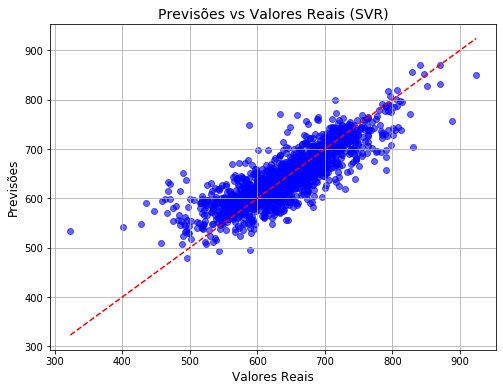

In [41]:
# Gráfico de dispersão (scatter plot) das previsões vs valores reais
plt.figure(figsize=(8, 6))
plt.scatter(y_test, svr_pred, alpha=0.6, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Linha de perfeição (y=x)
plt.title('Previsões vs Valores Reais (SVR)', fontsize=14)
plt.xlabel('Valores Reais', fontsize=12)
plt.ylabel('Previsões', fontsize=12)
plt.grid(True)
plt.show()

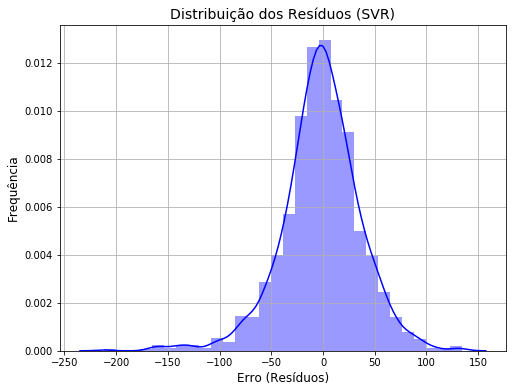

In [45]:
# Histograma dos resíduos (erros de previsão)
residuos = y_test - svr_pred
plt.figure(figsize=(8, 6))
sns.distplot(residuos, kde=True, color='blue', bins=30)
plt.title('Distribuição dos Resíduos (SVR)', fontsize=14)
plt.xlabel('Erro (Resíduos)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.grid(True)
plt.show()

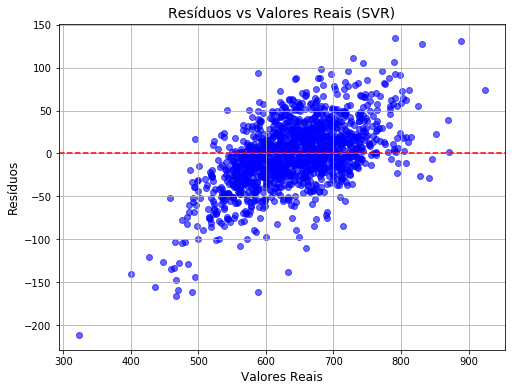

In [46]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuos, alpha=0.6, color='b')
plt.axhline(0, color='r', linestyle='--')  # Linha de referência em zero
plt.title('Resíduos vs Valores Reais (SVR)', fontsize=14)
plt.xlabel('Valores Reais', fontsize=12)
plt.ylabel('Resíduos', fontsize=12)
plt.grid(True)
plt.show()

                                       Importance
curso_smoothed                          18.611339
QT_INSCRICAO                            10.829508
QT_VAGAS_CONCORRENCIA                    5.623530
IA_Q5                                    5.046452
IGC                                      4.164389
POP                                      3.732275
GRUPO_HIERARQUIA_URBANA                  3.548805
CI                                       2.874119
DS_REGIAO_CAMPUS_Norte                   2.693966
DS_REGIAO_CAMPUS_Nordeste                1.735216
DS_REGIAO_CAMPUS_Sul                     1.603329
DS_CATEGORIA_ADM                         0.877201
DS_REGIAO_CAMPUS_Sudeste                 0.770375
DS_REGIAO_CAMPUS_Centro_Oeste            0.607541
DS_GRAU_Bacharelado                      0.463188
DS_TURNO_Integral                        0.375810
DS_GRAU_Licenciatura                     0.365659
DS_TURNO_Matutino                        0.316434
DS_TURNO_Noturno                         0.293310


<Figure size 720x432 with 0 Axes>

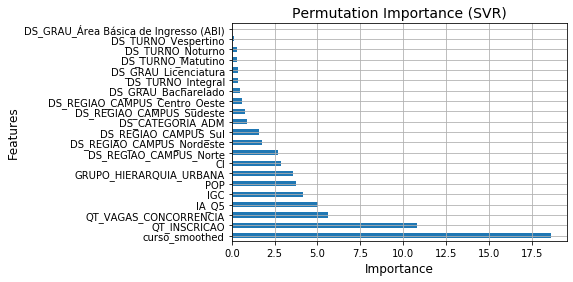

In [56]:
# Avaliar a importância das features usando Permutation Importance
result = permutation_importance(svr_best, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_absolute_error')

# Exibir a importância das features
importance_df = pd.DataFrame(result.importances_mean, index=X.columns, columns=['Importance'])\
                    .sort_values(by='Importance', ascending=False)
print(importance_df)

# Gráfico da importância das variáveis
plt.figure(figsize=(10, 6))
importance_df.plot(kind='barh', legend=False)
plt.title('Permutation Importance (SVR)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(True)
plt.show()